<a href="https://colab.research.google.com/github/nemathew/digitize-paper-forms/blob/master/TextFieldTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content

/content


# Set Up of Requirements for Object Detection #

Here we are installing the system requirements for the Tensorflow Models API specifically focusing on Object Detection. 

In [0]:
# Install Requirements
#!pip install tensorflow==1.9.0
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython
!pip install --user contextlib2
!pip install --user matplotlib

# Clone Tensorflow Models Repo
!git clone https://github.com/tensorflow/models.git
  
# Change directory to /content/models/research/
%cd /content/models/research/

# Set up Protoc for Object Detection
!protoc object_detection/protos/*.proto --python_out=.

# Append to OS PYTHONPATH the models for research
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

# Test Object Detection API installation is correct
!python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pil is already the newest version (5.1.0-1).
python-tk is already the newest version (2.7.15~rc1-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Cloning into 'models'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24089 (delta 16), reused 10 (delta 8), pack-reused 24059
Receiving objects: 100% (24089/24089), 505.74 MiB | 32.58 MiB/s, done.
Resolving deltas: 100% (14252/14252), done.
Checking out files: 100% (2768/2768), done.
/content/models/research

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on function

In [0]:
! pip list | grep tensorflow


mesh-tensorflow                    0.0.5                
tensorflow                         1.13.0rc1            
tensorflow-estimator               1.13.0rc0            
tensorflow-hub                     0.2.0                
tensorflow-metadata                0.9.0                
tensorflow-probability             0.5.0                


# Grabbing Dataset from Google Drive
In the following cell, we specify the zip file ID as the fileID found through Google Drive. We then pass through Authentication and extract all files from the zip file. 

Lastly, we access the images directory to get file names and place these in the annotations file trainval.txt

In [0]:
!pip install PyDrive

In [0]:
%cd /datalab
!echo -e "item {\n id: 1\n name: 'textfield'\n}" > pet_label_map.pbtxt

#fileId = '1RUxIrcWrT8tZtPdH4MwF63o6SFIo2I9x'

fileId = '1tcb7kuMS-lS2KT-OAexeR-D1A2T__d7r'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

/datalab
Extracted zip file 1tcb7kuMS-lS2KT-OAexeR-D1A2T__d7r.zip


#Sets up empty PNG files
This serves as a mask to avoid error in create_pet_tf_record.py (not used in training model).

In [0]:
!ls



annotations  images  pet_label_map.pbtxt  run.sh  web


In [0]:
%cd /datalab/annotations
!ls
# vvv UNCOMMENT THIS WHEN RUNNING ON NEW SESSION vvv
#!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')
  

/datalab/annotations
trainval.txt  xmls


# Creating TFRecord
Based off of pretrained model from COCO

In [0]:
!pwd
%cd /datalab

!python /content/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=pet_label_map.pbtxt --data_dir=. --output_dir=. --num_shards=10

!mv pet_faces_train.record-00000-of-00010 tf_train.record

!mv pet_faces_val.record-00000-of-00010 tf_val.record

/datalab/annotations
/datalab
/content/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [0]:
!ls

annotations			       pet_faces_val.record-00003-of-00010
images				       pet_faces_val.record-00004-of-00010
pet_faces_train.record-00001-of-00010  pet_faces_val.record-00005-of-00010
pet_faces_train.record-00002-of-00010  pet_faces_val.record-00006-of-00010
pet_faces_train.record-00003-of-00010  pet_faces_val.record-00007-of-00010
pet_faces_train.record-00004-of-00010  pet_faces_val.record-00008-of-00010
pet_faces_train.record-00005-of-00010  pet_faces_val.record-00009-of-00010
pet_faces_train.record-00006-of-00010  pet_label_map.pbtxt
pet_faces_train.record-00007-of-00010  run.sh
pet_faces_train.record-00008-of-00010  tf_train.record
pet_faces_train.record-00009-of-00010  tf_val.record
pet_faces_val.record-00001-of-00010    web
pet_faces_val.record-00002-of-00010


#Download Pre-trained Model

In [0]:
%cd /datalab

import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)


/datalab


#Edit Config File of Model

In [0]:
%cd /datalab

import re

#filename = '/content/datalab/pretrained_model/pipeline.config'
filename = '/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('/content/datalab', '/datalab', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/content/datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/content/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/content/datalab/pet_label_map.pbtxt', s)
  s = re.sub('/content/datalab', '/datalab', s)
  s = re.sub('keep_aspect_ratio_resizer', 'fixed_shape_resizer', s)
  s = re.sub('min_dimension: 600', 'height: 600', s)
  s = re.sub('max_dimension: 1024', 'width: 1024', s)
  f.write(s)
  
  !ls

/datalab
annotations			       pet_faces_val.record-00004-of-00010
images				       pet_faces_val.record-00005-of-00010
pet_faces_train.record-00001-of-00010  pet_faces_val.record-00006-of-00010
pet_faces_train.record-00002-of-00010  pet_faces_val.record-00007-of-00010
pet_faces_train.record-00003-of-00010  pet_faces_val.record-00008-of-00010
pet_faces_train.record-00004-of-00010  pet_faces_val.record-00009-of-00010
pet_faces_train.record-00005-of-00010  pet_label_map.pbtxt
pet_faces_train.record-00006-of-00010  pretrained_model
pet_faces_train.record-00007-of-00010  run.sh
pet_faces_train.record-00008-of-00010  tf_train.record
pet_faces_train.record-00009-of-00010  tf_val.record
pet_faces_val.record-00001-of-00010    trained
pet_faces_val.record-00002-of-00010    web
pet_faces_val.record-00003-of-00010


In [0]:
!cat /content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 37
    image_resizer {
      fixed_shape_resizer {
        height: 600
        width: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initia

#Train Model

In [0]:
%cd /datalab

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=/datalab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500

/datalab
/content/models/research/object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/content/models/research/object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/content/models/research/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/content/models/research/object_detection/eval_util.py", line 27, in <module>
    from object_detection.metrics import coco_evaluation
  File "/content/models/research/object_detection/metrics/coco_evaluation.py", line 20, in <module>
    from object_detection.metrics import coco_tools
  File "/content/models/research/ob

In [0]:
%cd /datalab
!pwd
!ls

/datalab
/datalab
annotations			       pet_faces_val.record-00004-of-00010
images				       pet_faces_val.record-00005-of-00010
pet_faces_train.record-00001-of-00010  pet_faces_val.record-00006-of-00010
pet_faces_train.record-00002-of-00010  pet_faces_val.record-00007-of-00010
pet_faces_train.record-00003-of-00010  pet_faces_val.record-00008-of-00010
pet_faces_train.record-00004-of-00010  pet_faces_val.record-00009-of-00010
pet_faces_train.record-00005-of-00010  pet_label_map.pbtxt
pet_faces_train.record-00006-of-00010  pretrained_model
pet_faces_train.record-00007-of-00010  run.sh
pet_faces_train.record-00008-of-00010  tf_train.record
pet_faces_train.record-00009-of-00010  tf_val.record
pet_faces_val.record-00001-of-00010    trained
pet_faces_val.record-00002-of-00010    web
pet_faces_val.record-00003-of-00010


#Export Model

Export model with best results

In [0]:
%cd /datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

/datalab
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
351 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence           

#Upload image to test model

Upload an image to use in a inference test of the trained model

In [0]:
%cd /datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/datalab


Saving test_htf_05.JPG to test_htf_05.JPG
saved file test_htf_05.JPG


In [0]:
%cd /datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image2.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/datalab


#Inference Test of Model

Using uploaded image, test model and output results

/content/models/research/object_detection
[[{'id': 1, 'name': u'textfield'}, 0.8854992, array([0.0552105 , 0.        , 0.49376598, 1.        ], dtype=float32)], [{'id': 1, 'name': u'textfield'}, 0.8854992, array([0.0552105 , 0.        , 0.49376598, 1.        ], dtype=float32)], [{'id': 1, 'name': u'textfield'}, 0.8854992, array([0.0552105 , 0.        , 0.49376598, 1.        ], dtype=float32)], [{'id': 1, 'name': u'textfield'}, 0.8854992, array([0.0552105 , 0.        , 0.49376598, 1.        ], dtype=float32)], [{'id': 1, 'name': u'textfield'}, 0.8854992, array([0.0552105 , 0.        , 0.49376598, 1.        ], dtype=float32)], [{'id': 1, 'name': u'textfield'}, 0.8854992, array([0.0552105 , 0.        , 0.49376598, 1.        ], dtype=float32)], [None, 0.004888436, array([0.37039563, 0.03392411, 0.4714178 , 0.04679557], dtype=float32)], [{'id': 1, 'name': u'textfield'}, 0.8854992, array([0.0552105 , 0.        , 0.49376598, 1.        ], dtype=float32)], [{'id': 1, 'name': u'textfield'}, 0.88

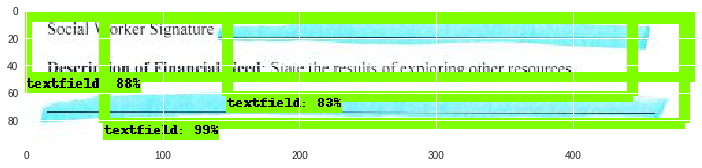

In [0]:
%cd /content/models/research/object_detection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
#  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/datalab/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/datalab', 'pet_label_map.pbtxt')

NUM_CLASSES = 37




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  
print([[category_index.get(i), output_dict['detection_scores'][i], output_dict['detection_boxes'][i]] for i in output_dict['detection_classes']])